<a href="https://colab.research.google.com/github/spaarky/portfolio/blob/main/cnn_generator_captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, BatchNormalization
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Mount Google Drive to access files stored in Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the folder containing the data in Google Drive
folder_path = '/content/drive/MyDrive/Data/Flicker30k/'

# List all files in the specified directory
files = os.listdir(folder_path)

# Print the list of files to the console
print(files)


['Images', 'captions.txt', 'working']


In [ ]:
# Define the base directory where the Flicker30k dataset is stored in Google Drive
BASE_DIR = '/content/drive/MyDrive/Data/Flicker30k'

# Define the working directory where processed data or intermediate files will be stored
WORKING_DIR = '/content/drive/MyDrive/Data/Flicker30k/working'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


  0%|          | 0/31783 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

NameError: name 'features' is not defined

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158915 [00:00<?, ?it/s]

In [ ]:
len(mapping)

31783

In [ ]:
def clean(mapping):
    """
    Preprocesses the captions in the given mapping dictionary.

    This function processes each caption in the mapping dictionary by performing several steps:
    1. Converts the caption to lowercase.
    2. Attempts to remove digits, special characters, and punctuation (note: replace() does not handle regex patterns, consider using regex for this).
    3. Attempts to remove additional spaces (note: replace() does not handle regex patterns, consider using regex for this).
    4. Adds 'startseq' at the beginning and 'endseq' at the end of the caption.
    5. Filters out words with one or fewer characters.

    Parameters:
    mapping (dict): A dictionary where each key is an image ID and each value is a list of captions (strings).

    Returns:
    None: The function updates the captions in place within the provided dictionary.
    """
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert caption to lowercase
            caption = caption.lower()
            # Delete digits, special characters, and punctuation
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # Update the caption in the list
            captions[i] = caption


In [ ]:
# before preprocess of text
mapping['1000092795']

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young   White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [ ]:
# Initialize an empty list to store all captions
all_captions = []

# Iterate through each key in the mapping dictionary
for key in mapping:
    # Iterate through each caption associated with the current key
    for caption in mapping[key]:
        # Append each caption to the list of all captions
        all_captions.append(caption)


In [ ]:
# Get the total number of captions collected in the all_captions list
len(all_captions)

158914

In [2]:
# Display the first 10 captions from the all_captions list
all_captions[:10]

NameError: name 'all_captions' is not defined

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [1]:
# Get the total number vocab_size
vocab_size

NameError: name 'vocab_size' is not defined

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [ ]:
# Get a list of all image IDs from the mapping dictionary
image_ids = list(mapping.keys())

# Calculate the split index for dividing the dataset into training and validation/testing sets
split = int(len(image_ids) * 0.80)

# Divide the image IDs into training and validation/testing sets
train = image_ids[:split]  # Training set: first 80% of the image IDs
val_test = image_ids[split:]  # Validation and testing set: remaining 20% of the image IDs

# Further split the validation/testing set into validation and testing sets
split2 = int(len(val_test) * 0.50)
test = val_test[:split2]  # Testing set: first 50% of the validation/testing set
val = val_test[split2:]  # Validation set: remaining 50% of the validation/testing set


In [ ]:
# Create a data generator to yield data in batches
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize lists to collect batch data
    X1, X2, y = list(), list(), list()
    n = 0  # Counter to track the number of samples processed

    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]  # Retrieve captions for the current image ID

            # Process each caption for the current image
            for caption in captions:
                # Encode the caption into a sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs from the sequence
                for i in range(1, len(seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad the input sequence to ensure uniform length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # One-hot encode the output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append the image features, input sequence, and output sequence to lists
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            # Yield a batch of data when the batch size is reached
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                # Reset lists and counter for the next batch
                X1, X2, y = list(), list(), list()
                n = 0


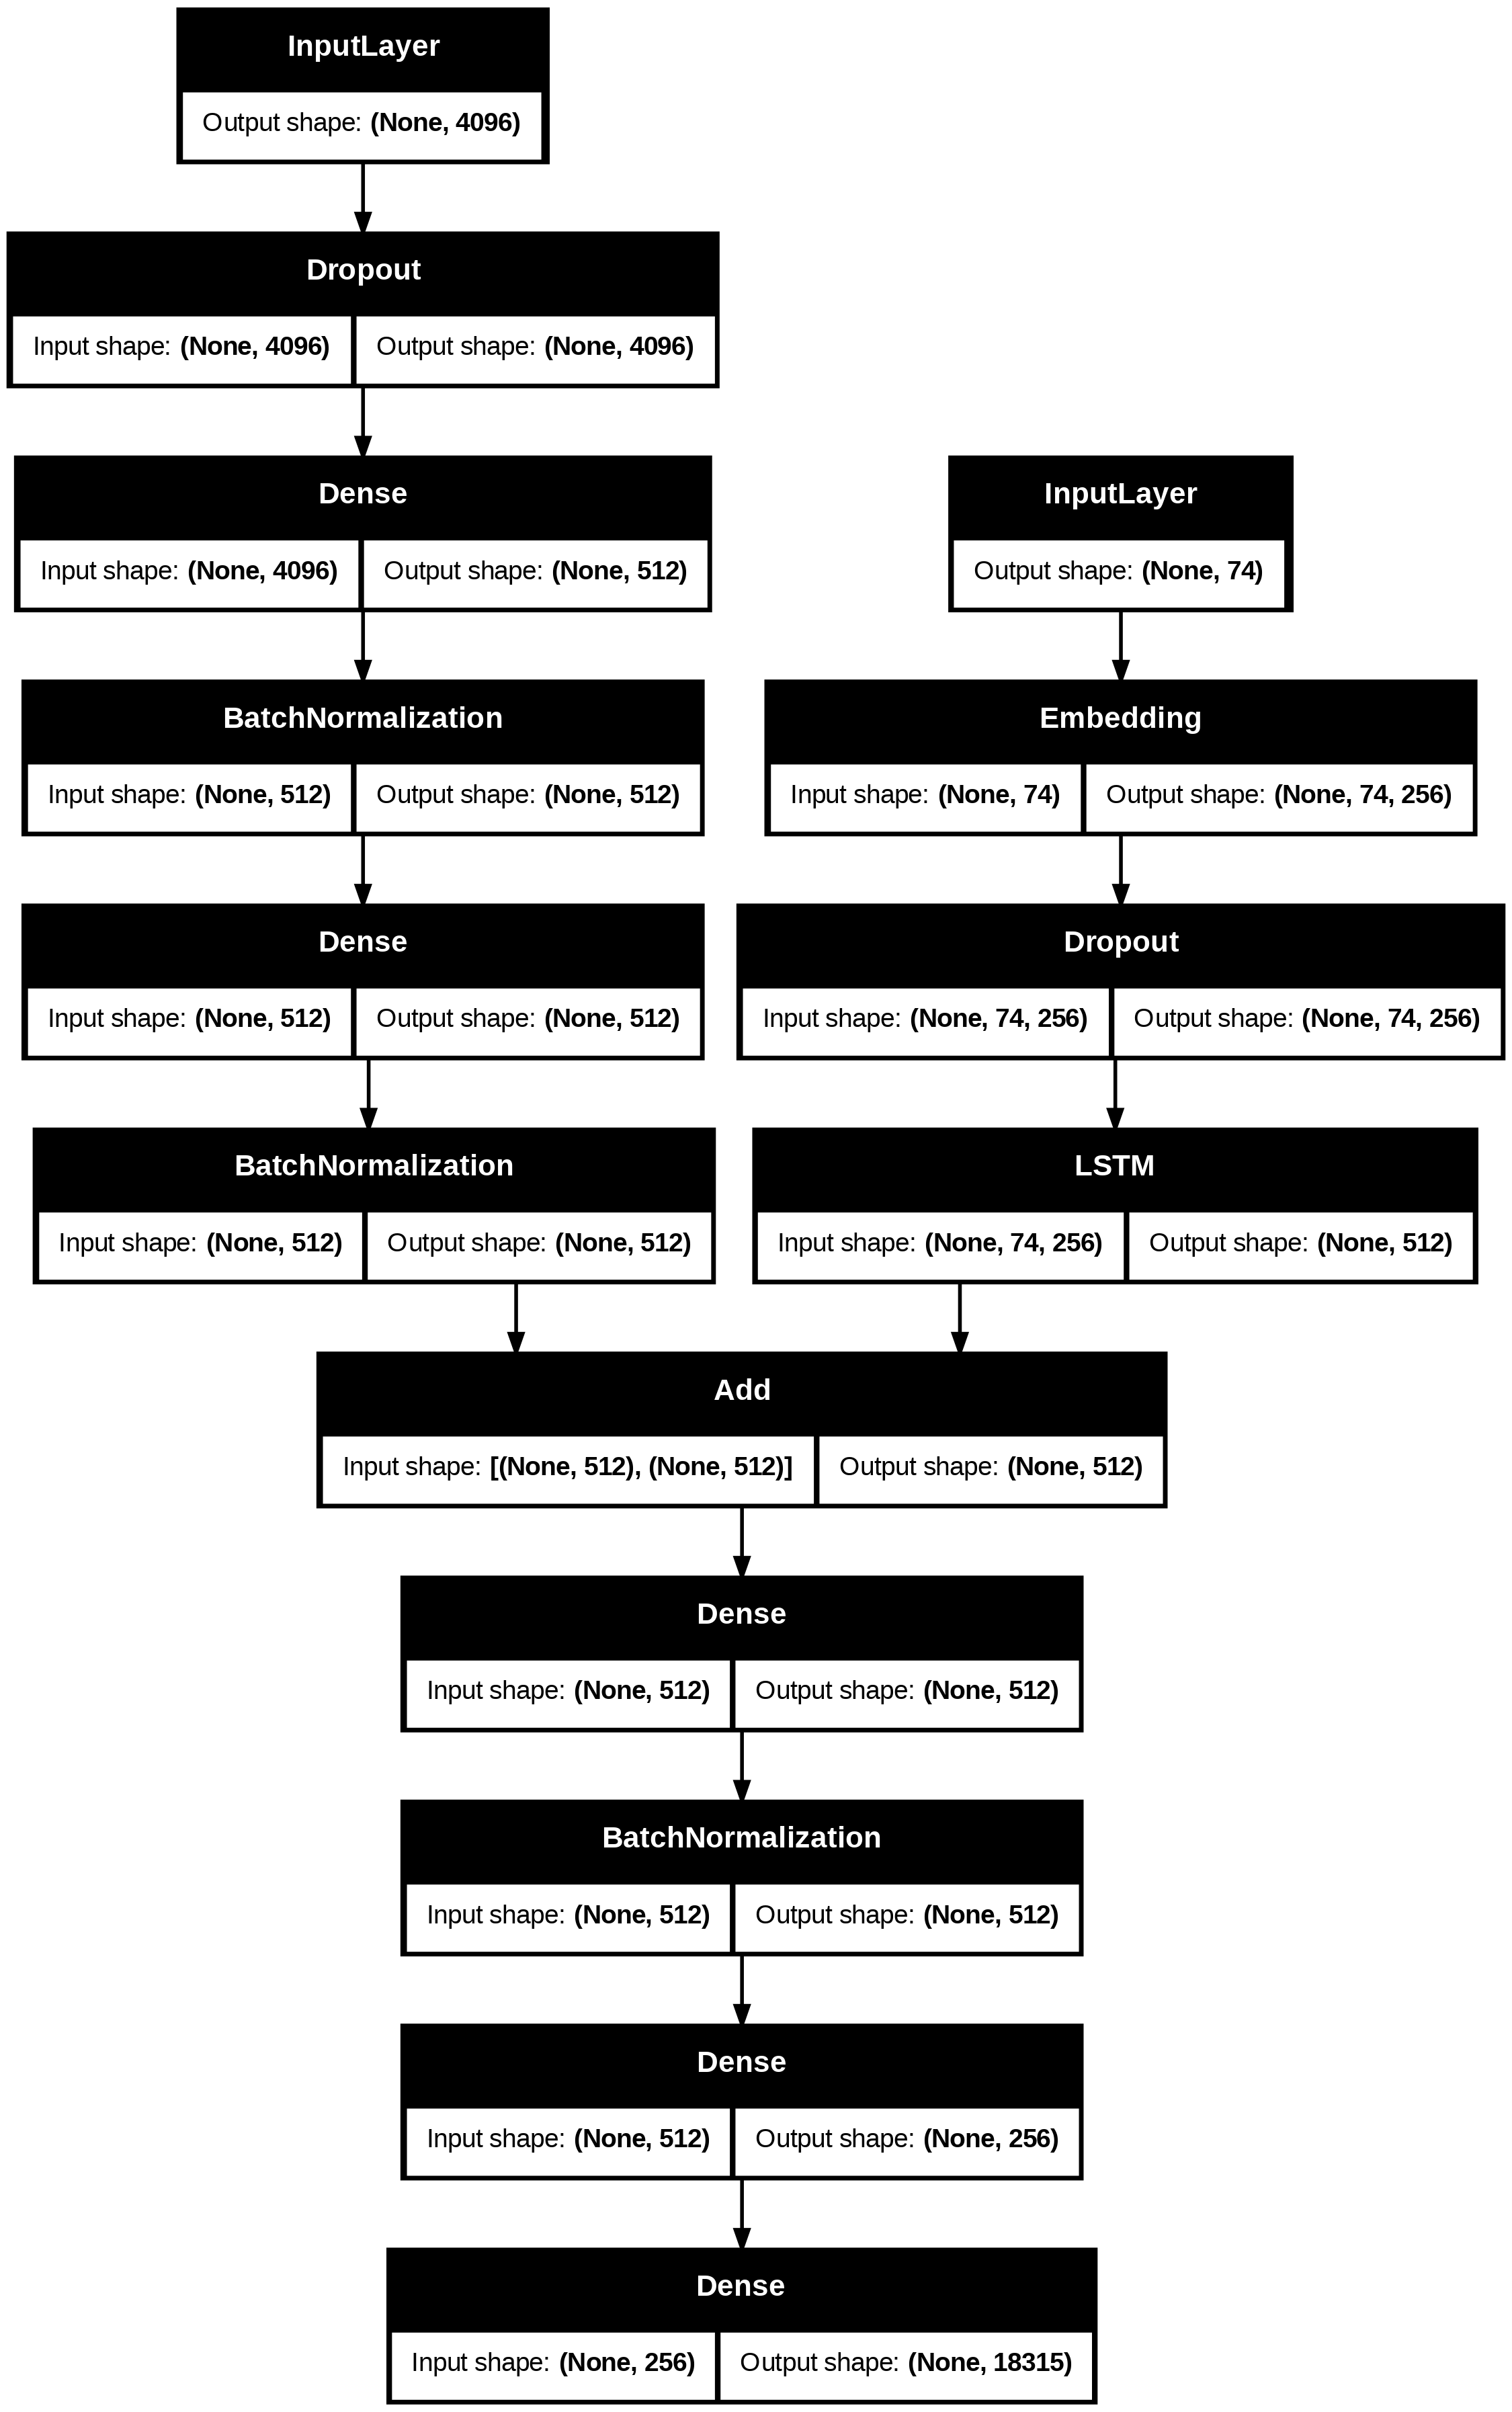

In [ ]:
# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,), name="image")  # Input layer for image features with 4096 dimensions
fe1 = Dropout(0.4)(inputs1)  # Dropout layer with a rate of 0.4 to reduce overfitting
fe2 = Dense(512, activation='relu')(fe1)  # Fully connected layer with 512 units and ReLU activation
fe3 = BatchNormalization()(fe2)  # BatchNormalization to normalize activations
fe4 = Dense(512, activation='relu')(fe3)  # Another fully connected layer with 512 units and ReLU activation
fe5 = BatchNormalization()(fe4)  # BatchNormalization to normalize activations

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")  # Input layer for text sequences with variable length
se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)  # Embedding layer with vocab_size and 256 dimensions
se2 = Dropout(0.4)(se1)  # Dropout layer with a rate of 0.4 to reduce overfitting
se3 = LSTM(512)(se2)  # LSTM layer with 512 units to process sequences

# Decoder model
decoder1 = add([fe5, se3])  # Combine image and sequence features using element-wise addition
decoder2 = Dense(512, activation='relu')(decoder1)  # Fully connected layer with 512 units and ReLU activation
decoder3 = BatchNormalization()(decoder2)  # BatchNormalization to normalize activations
decoder4 = Dense(256, activation='relu')(decoder3)  # Another fully connected layer with 256 units and ReLU activation
outputs = Dense(vocab_size, activation='softmax')(decoder4)  # Output layer with vocab_size units and softmax activation for classification

# Define and compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)  # Create a model with specified inputs and outputs
model.compile(loss='categorical_crossentropy', optimizer='adam')  # Compile the model with categorical crossentropy loss and Adam optimizer

# Plot the model architecture
plot_model(model, show_shapes=True)  # Visualize the model architecture with shape information



In [ ]:
# Train the model
epochs = 20  # Number of epochs to train the model
batch_size = 32  # Number of samples per batch
steps = len(train) // batch_size  # Number of steps per epoch (batches per epoch)

for i in range(epochs):
    # Create data generator for the current epoch
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit the model for one epoch using the data generator
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


794/794 ━━━━━━━━━━━━━━━━━━━━ 205s 255ms/step - loss: 5.3230
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 255ms/step - loss: 3.8298
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 3.5129
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 3.3087
794/794 ━━━━━━━━━━━━━━━━━━━━ 202s 255ms/step - loss: 3.1513
794/794 ━━━━━━━━━━━━━━━━━━━━ 204s 257ms/step - loss: 3.0219
794/794 ━━━━━━━━━━━━━━━━━━━━ 204s 257ms/step - loss: 2.9154
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.8268
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.7519
794/794 ━━━━━━━━━━━━━━━━━━━━ 202s 255ms/step - loss: 2.6872
794/794 ━━━━━━━━━━━━━━━━━━━━ 204s 256ms/step - loss: 2.6291
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.5774
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.5314
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.4888
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/step - loss: 2.4505
794/794 ━━━━━━━━━━━━━━━━━━━━ 204s 257ms/step - loss: 2.4145
794/794 ━━━━━━━━━━━━━━━━━━━━ 203s 256ms/

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')


In [ ]:
# load the model
load_model(WORKING_DIR+'/best_model.h5')

<Functional name=functional_11, built=True>

In [ ]:
def idx_to_word(integer, tokenizer):
    """
    Convert an integer index to its corresponding word using the tokenizer.

    Args:
        integer (int): The index of the word.
        tokenizer (Tokenizer): The tokenizer used to map words to integers.

    Returns:
        str: The word corresponding to the given index, or None if the index is not found.
    """
    # Iterate over the word-index mapping in the tokenizer
    for word, index in tokenizer.word_index.items():
        # Check if the current index matches the given integer
        if index == integer:
            # Return the corresponding word
            return word
    # Return None if the integer index is not found
    return None


In [ ]:
# Generate a caption for a given image
def predict_caption(model, image, tokenizer, max_length):
    """
    Generate a caption for an image using a trained model.

    Args:
        model (Model): The trained caption generation model.
        image (numpy.ndarray): The image feature array.
        tokenizer (Tokenizer): The tokenizer used for encoding and decoding words.
        max_length (int): The maximum length of the generated caption sequence.

    Returns:
        str: The generated caption for the image.
    """
    # Initialize the caption with the start tag
    in_text = 'startseq'

    # Iterate to generate words up to the maximum length of the sequence
    for i in range(max_length):
        # Encode the current sequence of words into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to ensure uniform input size
        sequence = pad_sequences([sequence], max_length)
        # Predict the next word in the sequence
        yhat = model.predict([image, sequence], verbose=0)
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        # Convert the index to the corresponding word
        word = idx_to_word(yhat, tokenizer)
        # Stop if the predicted word is not found
        if word is None:
            break
        # Append the predicted word to the current sequence
        in_text += " " + word
        # Stop if the end tag is predicted
        if word == 'endseq':
            break

    # Return the generated caption with start and end tags removed
    return in_text.replace('startseq', '').replace('endseq', '').strip()


In [ ]:
# Validate the model using test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get the actual captions for the image
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split actual captions into lists of words
    actual_captions = [caption.split() for caption in captions]
    # Split the predicted caption into words
    y_pred = y_pred.split()
    # Append actual and predicted captions to their respective lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/6357 [00:00<?, ?it/s]

ValueError: Layer "functional" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 4096) dtype=float32>, <tf.Tensor 'data_1:0' shape=(1, 74) dtype=int32>]

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
image_path = '/content/drive/MyDrive/Data/Flicker30k/"image"'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

TclError: no display name and no $DISPLAY environment variable